## Building Analyst Agents with Swarms to write Business Reports

Solving a business problem often involves preparing a Business Case Report. This report comprehensively analyzes the problem, evaluates potential solutions, and provides evidence-based recommendations and an implementation plan to effectively address the issue and drive business value. While the process of preparing one requires an experienced business analyst, the workflow can be augmented using AI agents. Two candidates stick out as areas to work on:

- Developing an outline to solve the problem
- Doing background research and gathering data 
  
In this blog, we will explore how Swarms agents can be used to tackle a busuiness problem by outlining the solution, conducting background research and generating a preliminary report.

Before we proceed, this blog uses 3 API tools. Please obtain the following keys and store them in a `.env` file in the same folder as this file.

- **[OpenAI API](https://openai.com/blog/openai-api)** as `OPENAI_API_KEY`
- **[TavilyAI API](https://app.tavily.com/home)** `TAVILY_API_KEY`
- **[KayAI API](https://www.kay.ai/)** as `KAY_API_KEY`

In [1]:
import dotenv
dotenv.load_dotenv()  # Load environment variables from .env file

True

### Developing an Outline to solve the problem

Assume the business problem is: **How do we improve Nike's revenue in Q3 2024?** We first create a planning agent to break down the problem into dependent sub-problems.


#### Step 1. Defining the Data Model and Tool Schema

Using Pydantic, we define a structure to help the agent generate sub-problems. 

- **QueryType:** Questions are either standalone or involve a combination of multiple others
- **Query:** Defines structure of a question.
- **QueryPlan:** Allows generation of a dependency graph of sub-questions

In [29]:
import enum
from typing import List
from pydantic import Field, BaseModel

class QueryType(str, enum.Enum):
    """Enumeration representing the types of queries that can be asked to a question answer system."""

    SINGLE_QUESTION = "SINGLE"
    MERGE_MULTIPLE_RESPONSES = "MERGE_MULTIPLE_RESPONSES"

class Query(BaseModel):
    """Class representing a single question in a query plan."""

    id: int = Field(..., description="Unique id of the query")
    question: str = Field(
        ...,
        description="Question asked using a question answering system",
    )
    dependencies: List[int] = Field(
        default_factory=list,
        description="List of sub questions that need to be answered before asking this question",
    )
    node_type: QueryType = Field(
        default=QueryType.SINGLE_QUESTION,
        description="Type of question, either a single question or a multi-question merge",
    )

class QueryPlan(BaseModel):
    """Container class representing a tree of questions to ask a question answering system."""

    query_graph: List[Query] = Field(
        ..., description="The query graph representing the plan"
    )

    def _dependencies(self, ids: List[int]) -> List[Query]:
        """Returns the dependencies of a query given their ids."""
        
        return [q for q in self.query_graph if q.id in ids]

Also, a `tool_schema` needs to be defined. It is an instance of `QueryPlan` and is used to initialize the agent.

In [30]:
tool_schema = QueryPlan(
    query_graph = [query.dict() for query in [
        Query(
            id=1,
            question="How do we improve Nike's revenue in Q3 2024?",
            dependencies=[2],
            node_type=QueryType('SINGLE')
        ),
        # ... other queries ...
    ]]
)

#### Step 2. Defining the Planning Agent

We specify the query, task specification and an appropriate system prompt.

In [31]:
from swarm_models import OpenAIChat
from swarms import Agent

query = "How do we improve Nike's revenue in Q3 2024?"
task = f"Consider: {query}. Generate just the correct query plan in JSON format."
system_prompt = (
        "You are a world class query planning algorithm " 
        "capable of breaking apart questions into its " 
        "dependency queries such that the answers can be " 
        "used to inform the parent question. Do not answer " 
        "the questions, simply provide a correct compute " 
        "graph with good specific questions to ask and relevant " 
        "dependencies. Before you call the function, think " 
        "step-by-step to get a better understanding of the problem."
    )
llm = OpenAIChat(
    temperature=0.0, model_name="gpt-4", max_tokens=4000
)

Then, we proceed with agent definition.

In [32]:
# Initialize the agent
agent = Agent(
    agent_name="Query Planner",
    system_prompt=system_prompt,
    # Set the tool schema to the JSON string -- this is the key difference
    tool_schema=tool_schema,
    llm=llm,
    max_loops=1,
    autosave=True,
    dashboard=False,
    streaming_on=True,
    verbose=True,
    interactive=False,
    # Set the output type to the tool schema which is a BaseModel
    output_type=tool_schema, # or dict, or str
    metadata_output_type="json",
    # List of schemas that the agent can handle
    list_base_models=[tool_schema],
    function_calling_format_type="OpenAI",
    function_calling_type="json", # or soon yaml
)

#### Step 3. Obtaining Outline from Planning Agent 

We now run the agent, and since its output is in JSON format, we can load it as a dictionary.

In [11]:
generated_data = agent.run(task)

Initializing Autonomous Agent Query Planner...
Autonomous Agent Activated.
All systems operational. Executing task...

Loop 1 of 1




content='{\n  "main_query": "How do we improve Nike\'s revenue in Q3 2024?",\n  "sub_queries": [\n    {\n      "id": "1",\n      "query": "What is Nike\'s current revenue trend?"\n    },\n    {\n      "id": "2",\n      "query": "What are the projected market trends for the sports apparel industry in 2024?"\n    },\n    {\n      "id": "3",\n      "query": "What are the current successful strategies being used by Nike\'s competitors?",\n      "dependencies": ["2"]\n    },\n    {\n      "id": "4",\n      "query": "What are the current and projected economic conditions in Nike\'s major markets?",\n      "dependencies": ["2"]\n    },\n    {\n      "id": "5",\n      "query": "What are the current consumer preferences in the sports apparel industry?",\n      "dependencies": ["2"]\n    },\n    {\n      "id": "6",\n      "query": "What are the potential areas of

At times the agent could return extra content other than JSON. Below function will filter it out.

In [14]:
def process_json_output(content):
    # Find the index of the first occurrence of '```json\n'
    start_index = content.find('```json\n')
    if start_index == -1:
        # If '```json\n' is not found, return the original content
        return content
    # Return the part of the content after '```json\n' and remove the '```' at the end
    return content[start_index + len('```json\n'):].rstrip('`')

# Use the function to clean up the output
json_content = process_json_output(generated_data.content)

In [15]:
import json

# Load the JSON string into a Python object
json_object = json.loads(json_content)

# Convert the Python object back to a JSON string
json_content = json.dumps(json_object, indent=2)

# Print the JSON string
print(json_content)

{
  "main_query": "How do we improve Nike's revenue in Q3 2024?",
  "sub_queries": [
    {
      "id": "1",
      "query": "What is Nike's current revenue trend?"
    },
    {
      "id": "2",
      "query": "What are the projected market trends for the sports apparel industry in 2024?"
    },
    {
      "id": "3",
      "query": "What are the current successful strategies being used by Nike's competitors?",
      "dependencies": [
        "2"
      ]
    },
    {
      "id": "4",
      "query": "What are the current and projected economic conditions in Nike's major markets?",
      "dependencies": [
        "2"
      ]
    },
    {
      "id": "5",
      "query": "What are the current consumer preferences in the sports apparel industry?",
      "dependencies": [
        "2"
      ]
    },
    {
      "id": "6",
      "query": "What are the potential areas of improvement in Nike's current business model?",
      "dependencies": [
        "1"
      ]
    },
    {
      "id": "7",
     

The JSON dictionary is not convenient for humans to process. We make a directed graph out of it.

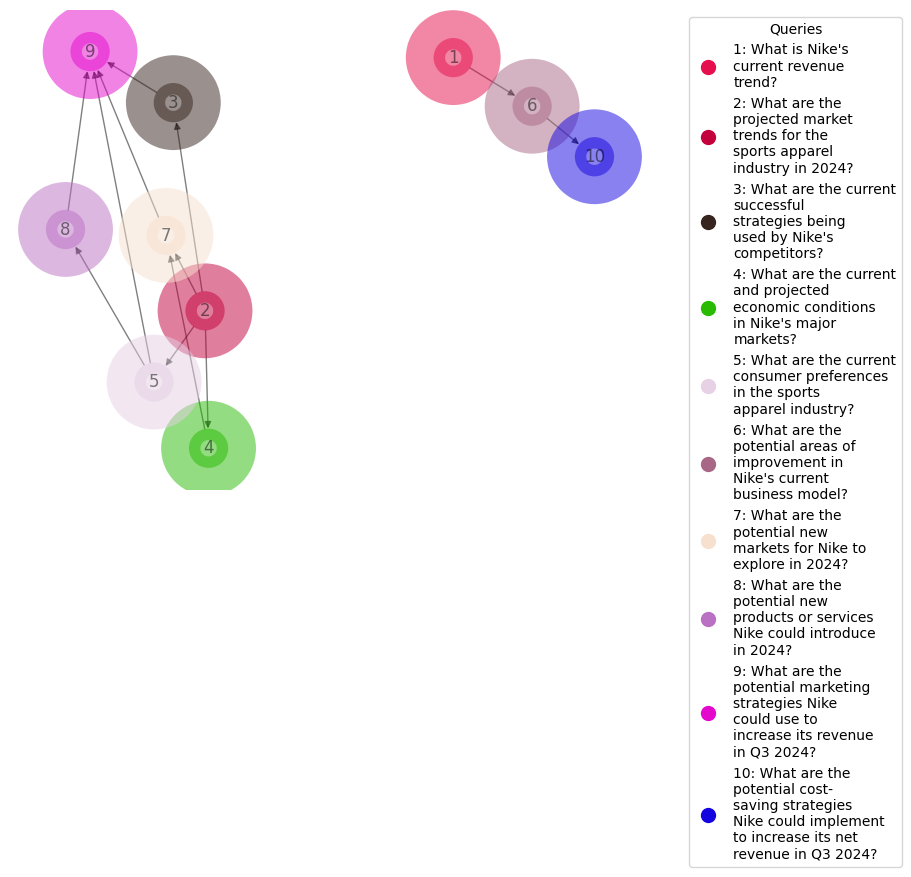

In [20]:
import networkx as nx
import matplotlib.pyplot as plt
import textwrap
import random

# Create a directed graph
G = nx.DiGraph()

# Define a color map
color_map = {}

# Add nodes and edges to the graph
for sub_query in json_object['sub_queries']:
    # Check if 'dependencies' key exists in sub_query, if not, initialize it as an empty list
    if 'dependencies' not in sub_query:
        sub_query['dependencies'] = []
    # Assign a random color for each node
    color_map[sub_query['id']] = "#{:06x}".format(random.randint(0, 0xFFFFFF))
    G.add_node(sub_query['id'], label=textwrap.fill(sub_query['query'], width=20))
    for dependency in sub_query['dependencies']:
        G.add_edge(dependency, sub_query['id'])

# Draw the graph
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=800, node_color=[color_map[node] for node in G.nodes()], node_shape="o", alpha=0.5, linewidths=40)

# Prepare labels for legend
labels = nx.get_node_attributes(G, 'label')
handles = [plt.Line2D([0], [0], marker='o', color=color_map[node], label=f"{node}: {label}", markersize=10, linestyle='None') for node, label in labels.items()]

# Create a legend
plt.legend(handles=handles, title="Queries", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

### Doing Background Research and Gathering Data

At this point, we have solved the first half of the problem. We have an outline consisting of sub-problems to to tackled to solve our business problem. This will form the overall structure of our report. We now need to research information for each sub-problem in order to write an informed report. This mechanically intensive and is the aspect that will most benefit from Agentic intervention. 

Essentially, we can spawn parallel agents to gather the data. Each agent will have 2 tools:

- Internet access
- Financial data retrieval

As they run parallely, they will add their knowledge into a common long-term memory. We will then spawn a separate report writing agent with access to this memory to generate our business case report.

#### Step 4. Defining Tools for Worker Agents

Let us first define the 2 tools. 

In [33]:
import os
from typing import List

from swarms import tool

os.environ['TAVILY_API_KEY'] = os.getenv('TAVILY_API_KEY')
os.environ["KAY_API_KEY"] = os.getenv('KAY_API_KEY')

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.pydantic_v1 import BaseModel, Field

from kay.rag.retrievers import KayRetriever

@tool
def browser(query: str) -> str:
    """
    Search the query in the browser with the Tavily API tool.
    Args:
        query (str): The query to search in the browser.
    Returns:
        str: The search results
    """
    internet_search = TavilySearchResults()
    results =  internet_search.invoke({"query": query})
    response = '' 
    for result in results:
        response += (result['content'] + '\n')
    return response

@tool
def kay_retriever(query: str) -> str:
    """
    Search the financial data query with the KayAI API tool.
    Args:
        query (str): The query to search in the KayRetriever.
    Returns:
        str: The first context retrieved as a string.
    """
    # Initialize the retriever
    retriever = KayRetriever(dataset_id = "company",  data_types=["10-K", "10-Q", "8-K", "PressRelease"])
    # Query the retriever
    context = retriever.query(query=query,num_context=1)
    return context[0]['chunk_embed_text']

#### Step 5. Defining Long-Term Memory

As mentioned previously, the worker agents running parallely, will pool their knowledge into a common memory. Let us define that.


In [174]:
import logging
import os
import uuid
from typing import Callable, List, Optional

import chromadb
from dotenv import load_dotenv

from swarms.utils.data_to_text import data_to_text
from swarms.utils.markdown_message import display_markdown_message
from swarms_memory import  AbstractVectorDatabase

# Load environment variables
load_dotenv()

# Results storage using local ChromaDB
class ChromaDB(AbstractVectorDatabase):
    """

    ChromaDB database

    Args:
        metric (str): The similarity metric to use.
        output (str): The name of the collection to store the results in.
        limit_tokens (int, optional): The maximum number of tokens to use for the query. Defaults to 1000.
        n_results (int, optional): The number of results to retrieve. Defaults to 2.

    Methods:
        add: _description_
        query: _description_

    Examples:
        >>> chromadb = ChromaDB(
        >>>     metric="cosine",
        >>>     output="results",
        >>>     llm="gpt3",
        >>>     openai_api_key=OPENAI_API_KEY,
        >>> )
        >>> chromadb.add(task, result, result_id)
    """

    def __init__(
        self,
        metric: str = "cosine",
        output_dir: str = "swarms",
        limit_tokens: Optional[int] = 1000,
        n_results: int = 3,
        embedding_function: Callable = None,
        docs_folder: str = None,
        verbose: bool = False,
        *args,
        **kwargs,
    ):
        self.metric = metric
        self.output_dir = output_dir
        self.limit_tokens = limit_tokens
        self.n_results = n_results
        self.docs_folder = docs_folder
        self.verbose = verbose

        # Disable ChromaDB logging
        if verbose:
            logging.getLogger("chromadb").setLevel(logging.INFO)

        # Create Chroma collection
        chroma_persist_dir = "chroma"
        chroma_client = chromadb.PersistentClient(
            settings=chromadb.config.Settings(
                persist_directory=chroma_persist_dir,
            ),
            *args,
            **kwargs,
        )

        # Embedding model
        if embedding_function:
            self.embedding_function = embedding_function
        else:
            self.embedding_function = None

        # Create ChromaDB client
        self.client = chromadb.Client()

        # Create Chroma collection
        self.collection = chroma_client.get_or_create_collection(
            name=output_dir,
            metadata={"hnsw:space": metric},
            embedding_function=self.embedding_function,
            # data_loader=self.data_loader,
            *args,
            **kwargs,
        )
        display_markdown_message(
            "ChromaDB collection created:"
            f" {self.collection.name} with metric: {self.metric} and"
            f" output directory: {self.output_dir}"
        )

        # If docs
        if docs_folder:
            display_markdown_message(
                f"Traversing directory: {docs_folder}"
            )
            self.traverse_directory()

    def add(
        self,
        document: str,
        *args,
        **kwargs,
    ):
        """
        Add a document to the ChromaDB collection.

        Args:
            document (str): The document to be added.
            condition (bool, optional): The condition to check before adding the document. Defaults to True.

        Returns:
            str: The ID of the added document.
        """
        try:
            doc_id = str(uuid.uuid4())
            self.collection.add(
                ids=[doc_id],
                documents=[document],
                *args,
                **kwargs,
            )
            print('-----------------')
            print("Document added successfully")
            print('-----------------')
            return doc_id
        except Exception as e:
            raise Exception(f"Failed to add document: {str(e)}")

    def query(
        self,
        query_text: str,
        *args,
        **kwargs,
    ):
        """
        Query documents from the ChromaDB collection.

        Args:
            query (str): The query string.
            n_docs (int, optional): The number of documents to retrieve. Defaults to 1.

        Returns:
            dict: The retrieved documents.
        """
        try:
            docs = self.collection.query(
                query_texts=[query_text],
                n_results=self.n_results,
                *args,
                **kwargs,
            )["documents"]
            return docs[0]
        except Exception as e:
            raise Exception(f"Failed to query documents: {str(e)}")

    def traverse_directory(self):
        """
        Traverse through every file in the given directory and its subdirectories,
        and return the paths of all files.
        Parameters:
        - directory_name (str): The name of the directory to traverse.
        Returns:
        - list: A list of paths to each file in the directory and its subdirectories.
        """
        added_to_db = False

        for root, dirs, files in os.walk(self.docs_folder):
            for file in files:
                file = os.path.join(self.docs_folder, file)
                _, ext = os.path.splitext(file)
                data = data_to_text(file)
                added_to_db = self.add([data])
                print(f"{file} added to Database")

        return added_to_db

We can now proceed to initialize the memory.

In [175]:
from chromadb.utils import embedding_functions
default_ef = embedding_functions.DefaultEmbeddingFunction()

memory = ChromaDB(
    metric="cosine",
    n_results=3,
    output_dir="results",
    embedding_function=default_ef
)

ChromaDB collection created: results with metric: cosine and output directory: results


#### Step 6. Defining Worker Agents 

The Worker Agent sub-classes the `Agent` class. The only different between these 2 is in how the `run()` method works. In the `Agent` class, `run()` simply returns the set of tool commands to run, but does not execute it. We, however, desire this. In addition, after we run our tools, we get the relevant information as output. We want to add this information to our memory. Hence, to incorporate these 2 changes, we define `WorkerAgent` as follows.

In [176]:
class WorkerAgent(Agent):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def run(self, task, *args, **kwargs):
        response = super().run(task, *args, **kwargs)
        print(response.content)

        json_dict = json.loads(process_json_output(response.content))

        #print(json.dumps(json_dict, indent=2))
        
        if response!=None:
            try:
                commands = json_dict["commands"]
            except:
                commands = [json_dict['command']]
                
            for command in commands:
                tool_name = command["name"]

                if tool_name not in ['browser', 'kay_retriever']:
                    continue
                
                query = command["args"]["query"]

                # Get the tool by its name
                tool = globals()[tool_name]
                tool_response = tool(query)

                # Add tool's output to long term memory
                self.long_term_memory.add(tool_response)
    

We can then instantiate an object of the `WorkerAgent` class.

In [177]:
worker_agent = WorkerAgent(
    agent_name="Worker Agent",
    system_prompt=(
        "Autonomous agent that can interact with browser, "
        "financial data retriever and other agents. Be Helpful " 
        "and Kind. Use the tools provided to assist the user. "
        "Generate the plan with list of commands in JSON format."
    ),
    llm=OpenAIChat(
    temperature=0.0, model_name="gpt-4", max_tokens=4000
),
    max_loops="auto",
    autosave=True,
    dashboard=False,
    streaming_on=True,
    verbose=True,
    stopping_token="<DONE>",
    interactive=True,
    tools=[browser, kay_retriever],
    long_term_memory=memory,
    code_interpreter=True,
)


#### Step 7. Running the Worker Agents

At this point, we need to setup a concurrent workflow. While the order of adding tasks to the workflow doesn't matter (since they will all run concurrently late when executed), we can take some time to define an order for these tasks. This order will come in handy later when writing the report using our Writer Agent. 

The order we will follow is Breadth First Traversal (BFT) of the sub-queries in the graph we had made earlier (shown below again for reference). BFT makes sense to be used here because we want all the dependent parent questions to be answered before answering the child question. Also, since we could have independent subgraphs, we will also perform BFT separately on each subgraph. 


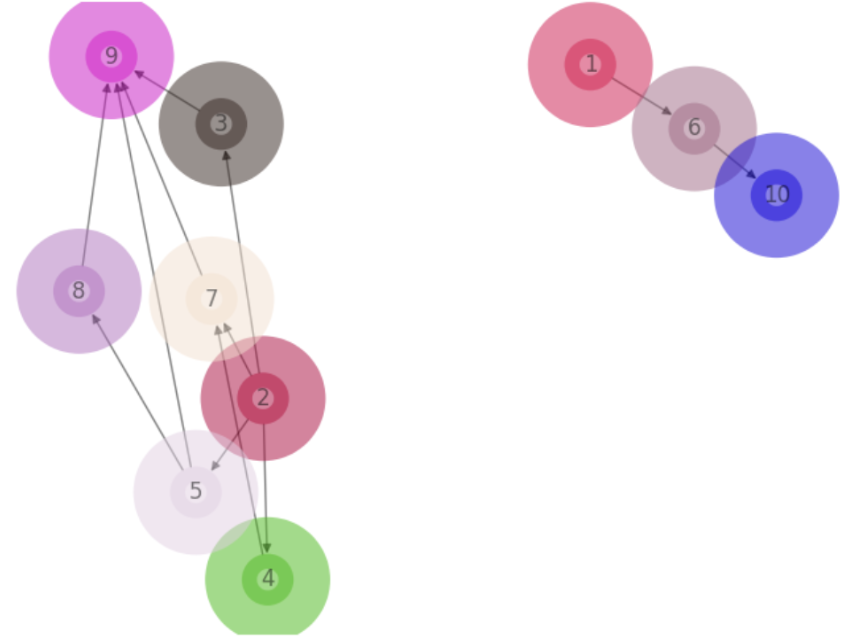

Below is the code that produces the order of processing sub-queries.

In [178]:
from collections import deque, defaultdict

# Define the graph nodes
nodes = json_object['sub_queries']

# Create a graph from the nodes
graph = defaultdict(list)
for node in nodes:
    for dependency in node['dependencies']:
        graph[dependency].append(node['id'])

# Find all nodes with no dependencies (potential starting points)
start_nodes = [node['id'] for node in nodes if not node['dependencies']]

# Adjust the BFT function to handle dependencies correctly
def bft_corrected(start, graph, nodes_info):
    visited = set()
    queue = deque([start])
    order = []
    
    while queue:
        node = queue.popleft()
        if node not in visited:
            # Check if all dependencies of the current node are visited
            node_dependencies = [n['id'] for n in nodes if n['id'] == node][0]
            dependencies_met = all(dep in visited for dep in nodes_info[node_dependencies]['dependencies'])
            
            if dependencies_met:
                visited.add(node)
                order.append(node)
                # Add only nodes to the queue whose dependencies are fully met
                for next_node in graph[node]:
                    if all(dep in visited for dep in nodes_info[next_node]['dependencies']):
                        queue.append(next_node)
            else:
                # Requeue the node to check dependencies later
                queue.append(node)
    
    return order

# Dictionary to access node information quickly
nodes_info = {node['id']: node for node in nodes}

# Perform BFt for each unvisited start node using the corrected BFS function
visited_global = set()
bfs_order = []

for start in start_nodes:
    if start not in visited_global:
        order = bft_corrected(start, graph, nodes_info)
        bfs_order.extend(order)
        visited_global.update(order)

print("BFS Order:", bfs_order)


BFS Order: ['1', '6', '10', '2', '3', '4', '5', '7', '8', '9']


Now, let's define our `ConcurrentWorkflow` and run it.

In [179]:
import os
from dotenv import load_dotenv
from swarms import Agent, ConcurrentWorkflow, OpenAIChat, Task

# Create a workflow
workflow = ConcurrentWorkflow(max_workers=5)
task_list = []

for node in bfs_order:
    sub_query =nodes_info[node]['query']
    task = Task(worker_agent, sub_query)
    print('-----------------')
    print("Added task: ", sub_query)
    print('-----------------')
    task_list.append(task)

workflow.add(tasks=task_list)

# Run the workflow
workflow.run()

-----------------
Added task:  What is Nike's current revenue trend?
-----------------
-----------------
Added task:  What are the potential areas of improvement in Nike's current business model?
-----------------
-----------------
Added task:  What are the potential cost-saving strategies Nike could implement to increase its net revenue in Q3 2024?
-----------------
-----------------
Added task:  What are the projected market trends for the sports apparel industry in 2024?
-----------------
-----------------
Added task:  What are the current successful strategies being used by Nike's competitors?
-----------------
-----------------
Added task:  What are the current and projected economic conditions in Nike's major markets?
-----------------
-----------------
Added task:  What are the current consumer preferences in the sports apparel industry?
-----------------
-----------------
Added task:  What are the potential new markets for Nike to explore in 2024?
-----------------
------------

In the above output this workflow produces, we clearly see the thought process of the agent and the plan it came up to solve a particular sub-query. In addition, we see the tool-calling schema it produces in `"command"`. Here, `"name"` pertains to the name of the tool to be called and `"args"` is the arguments to be passed to the tool call. Like mentioned before, we modify `Agent`'s default behaviour in `WorkerAgent`. Hence, the tool call is executed here and its results (information from web pages and Kay Retriever API) are added to long-term memory. We get confirmation for this from the message `Document added successfully`. 

#### Step 7. Generating the report using Writer Agent

At this point, our Worker Agents have gathered all the background information required to generate the report. We have also defined a coherent structure to write the report, which is following the BFT order to answering the sub-queries. Now it's time to define a Writer Agent and call it sequentially in the order of sub-queries. 

In [186]:
from swarms import Agent, OpenAIChat, tool

agent = Agent(
    agent_name="Writer Agent",
    agent_description=(
        "This agent writes reports based on information in long-term memory"
    ),
    system_prompt=(
        "You are a world-class financial report writer. " 
        "Write analytical and accurate responses using memory to answer the query. "
        "Do not mention use of long-term memory in the report. "
        "Do not mention Writer Agent in response."
        "Return only response content in strict markdown format."
    ),
    llm=OpenAIChat(temperature=0.2, model='gpt-3.5-turbo'),
    max_loops=1,
    autosave=True,
    verbose=True,
    long_term_memory=memory,
)


The report individual sections of the report will be collected in a list.

In [187]:
report = []

Let us now run the writer agent.

In [188]:
for node in bfs_order:
    sub_query =nodes_info[node]['query']
    print("Running task: ", sub_query)
    out = agent.run(f"Consider: {sub_query}. Write response in strict markdown format using long-term memory. Do not mention Writer Agent in response.")
    print(out)
    try:
        report.append(out.content)
    except:
        pass

Running task:  What is Nike's current revenue trend?
Initializing Autonomous Agent Writer agent...
Autonomous Agent Activated.
All systems operational. Executing task...

Loop 1 of 1




content="### Nike's Current Revenue Trend\n\nNike's current revenue trend has been steadily increasing over the past few years. In the most recent fiscal year, Nike reported a revenue of $37.4 billion, which was a 7% increase from the previous year. This growth can be attributed to strong sales in key markets, successful marketing campaigns, and a focus on innovation in product development. Overall, Nike continues to demonstrate strong financial performance and is well-positioned for future growth." response_metadata={'token_usage': {'completion_tokens': 95, 'prompt_tokens': 89, 'total_tokens': 184}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': 'fp_3b956da36b', 'finish_reason': 'stop', 'logprobs': None}
Saved agent state to: Writer agent_state.json
content="### Nike's Current Revenue Trend\n\nN

Now, we need to clean up the repoort a bit to make it render professionally. 

In [189]:
# Remove any content before the first "#" as that signals start of heading
# Anything before this usually contains filler content
stripped_report = [entry[entry.find('#'):] if '#' in entry else entry for entry in report]
report = stripped_report

In [190]:
report

["### Nike's Current Revenue Trend\n\nNike's current revenue trend has been steadily increasing over the past few years. In the most recent fiscal year, Nike reported a revenue of $37.4 billion, which was a 7% increase from the previous year. This growth can be attributed to strong sales in key markets, successful marketing campaigns, and a focus on innovation in product development. Overall, Nike continues to demonstrate strong financial performance and is well-positioned for future growth.",
 "### Potential Areas of Improvement in Nike's Business Model\n\n1. **Sustainability Practices**: Nike could further enhance its sustainability efforts by reducing its carbon footprint, using more eco-friendly materials, and ensuring ethical labor practices throughout its supply chain.\n\n2. **Diversification of Product Portfolio**: While Nike is known for its athletic footwear and apparel, diversifying into new product categories or expanding into untapped markets could help drive growth and mit

In [208]:
# At times the LLM outputs \\n instead of \n
cleaned_report = [entry.replace("\\n", "\n") for entry in report]
import re

# Function to clean up unnecessary metadata from the report entries
def clean_report(report):
    cleaned_report = []
    for entry in report:
        # This pattern matches 'response_metadata={' followed by any characters that are not '}' (non-greedy), 
        # possibly nested inside other braces, until the closing '}'.
        cleaned_entry = re.sub(r"response_metadata=\{[^{}]*(?:\{[^{}]*\}[^{}]*)*\}", "", entry, flags=re.DOTALL)
        cleaned_report.append(cleaned_entry)
    return cleaned_report

# Apply the cleaning function to the markdown report
cleaned_report = clean_report(cleaned_report)

After cleaning, we append parts of the report together to get out final report.

In [209]:
final_report = ' \n '.join(cleaned_report)
print(final_report)

### Nike's Current Revenue Trend

Nike's current revenue trend has been steadily increasing over the past few years. In the most recent fiscal year, Nike reported a revenue of $37.4 billion, which was a 7% increase from the previous year. This growth can be attributed to strong sales in key markets, successful marketing campaigns, and a focus on innovation in product development. Overall, Nike continues to demonstrate strong financial performance and is well-positioned for future growth. 
 ### Potential Areas of Improvement in Nike's Business Model

1. **Sustainability Practices**: Nike could further enhance its sustainability efforts by reducing its carbon footprint, using more eco-friendly materials, and ensuring ethical labor practices throughout its supply chain.

2. **Diversification of Product Portfolio**: While Nike is known for its athletic footwear and apparel, diversifying into new product categories or expanding into untapped markets could help drive growth and mitigate risk

## Final Generated Report

In Jupyter Notebook, we can use the below code to render it in Markdown. 

In [210]:
from IPython.display import display, Markdown

display(Markdown(final_report))

### Nike's Current Revenue Trend

Nike's current revenue trend has been steadily increasing over the past few years. In the most recent fiscal year, Nike reported a revenue of $37.4 billion, which was a 7% increase from the previous year. This growth can be attributed to strong sales in key markets, successful marketing campaigns, and a focus on innovation in product development. Overall, Nike continues to demonstrate strong financial performance and is well-positioned for future growth. 
 ### Potential Areas of Improvement in Nike's Business Model

1. **Sustainability Practices**: Nike could further enhance its sustainability efforts by reducing its carbon footprint, using more eco-friendly materials, and ensuring ethical labor practices throughout its supply chain.

2. **Diversification of Product Portfolio**: While Nike is known for its athletic footwear and apparel, diversifying into new product categories or expanding into untapped markets could help drive growth and mitigate risks associated with a single product line.

3. **E-commerce Strategy**: Improving the online shopping experience, investing in digital marketing, and leveraging data analytics to personalize customer interactions could boost online sales and customer loyalty.

4. **Innovation and R&D**: Continuously investing in research and development to stay ahead of competitors, introduce new technologies, and enhance product performance could help maintain Nike's competitive edge in the market.

5. **Brand Image and Reputation**: Strengthening brand image through effective marketing campaigns, community engagement, and transparent communication with stakeholders can help build trust and loyalty among consumers. 
 ### Potential Cost-Saving Strategies for Nike to Increase Net Revenue in Q3 2024

1. **Supply Chain Optimization**: Streamlining the supply chain, reducing transportation costs, and improving inventory management can lead to significant cost savings for Nike.

2. **Operational Efficiency**: Implementing lean manufacturing practices, reducing waste, and optimizing production processes can help lower production costs and improve overall efficiency.

3. **Outsourcing Non-Core Functions**: Outsourcing non-core functions such as IT services, customer support, or logistics can help reduce overhead costs and focus resources on core business activities.

4. **Energy Efficiency**: Investing in energy-efficient technologies, renewable energy sources, and sustainable practices can lower utility costs and demonstrate a commitment to environmental responsibility.

5. **Negotiating Supplier Contracts**: Negotiating better terms with suppliers, leveraging economies of scale, and exploring alternative sourcing options can help lower procurement costs and improve margins.

By implementing these cost-saving strategies, Nike can improve its bottom line and increase net revenue in Q3 2024. 
 ### Projected Market Trends for the Sports Apparel Industry in 2024

1. **Sustainable Fashion**: Consumers are increasingly demanding eco-friendly and sustainable products, leading to a rise in sustainable sportswear options in the market.

2. **Digital Transformation**: The sports apparel industry is expected to continue its shift towards digital platforms, with a focus on e-commerce, personalized shopping experiences, and digital marketing strategies.

3. **Athleisure Wear**: The trend of athleisure wear, which combines athletic and leisure clothing, is projected to remain popular in 2024 as consumers seek comfort and versatility in their apparel choices.

4. **Innovative Materials**: Advances in technology and material science are likely to drive the development of innovative fabrics and performance-enhancing materials in sports apparel, catering to the demand for high-quality and functional products.

5. **Health and Wellness Focus**: With a growing emphasis on health and wellness, sports apparel brands are expected to incorporate features that promote comfort, performance, and overall well-being in their products.

Overall, the sports apparel industry in 2024 is anticipated to be characterized by sustainability, digitalization, innovation, and a focus on consumer health and lifestyle trends. 
 ### Current Successful Strategies Used by Nike's Competitors

1. **Adidas**: Adidas has been successful in leveraging collaborations with celebrities and designers to create limited-edition collections that generate hype and drive sales. They have also focused on sustainability initiatives, such as using recycled materials in their products, to appeal to environmentally conscious consumers.

2. **Under Armour**: Under Armour has differentiated itself by targeting performance-driven athletes and emphasizing technological innovation in their products. They have also invested heavily in digital marketing and e-commerce to reach a wider audience and enhance the customer shopping experience.

3. **Puma**: Puma has successfully capitalized on the athleisure trend by offering stylish and versatile sportswear that can be worn both in and out of the gym. They have also focused on building partnerships with influencers and sponsoring high-profile athletes to increase brand visibility and credibility.

4. **Lululemon**: Lululemon has excelled in creating a strong community around its brand, hosting events, classes, and collaborations to engage with customers beyond just selling products. They have also prioritized customer experience by offering personalized services and creating a seamless omnichannel shopping experience.

5. **New Balance**: New Balance has carved out a niche in the market by emphasizing quality craftsmanship, heritage, and authenticity in their products. They have also focused on customization and personalization options for customers, allowing them to create unique and tailored footwear and apparel.

Overall, Nike's competitors have found success through a combination of innovative product offerings, strategic marketing initiatives, and a focus on customer engagement and experience. 
 ### Current and Projected Economic Conditions in Nike's Major Markets

1. **United States**: The United States, being one of Nike's largest markets, is currently experiencing moderate economic growth driven by consumer spending, low unemployment rates, and a rebound in manufacturing. However, uncertainties surrounding trade policies, inflation, and interest rates could impact consumer confidence and spending in the near future.

2. **China**: China remains a key market for Nike, with a growing middle class and increasing demand for sportswear and athletic footwear. Despite recent trade tensions with the U.S., China's economy is projected to continue expanding, driven by domestic consumption, infrastructure investments, and technological advancements.

3. **Europe**: Economic conditions in Europe vary across countries, with some experiencing sluggish growth due to Brexit uncertainties, political instability, and trade tensions. However, overall consumer confidence is improving, and the sports apparel market is expected to grow, driven by e-commerce and sustainability trends.

4. **Emerging Markets**: Nike's presence in emerging markets such as India, Brazil, and Southeast Asia provides opportunities for growth, given the rising disposable incomes, urbanization, and increasing focus on health and fitness. However, challenges such as currency fluctuations, regulatory changes, and competition from local brands could impact Nike's performance in these markets.

Overall, Nike's major markets exhibit a mix of opportunities and challenges, with economic conditions influenced by global trends, geopolitical factors, and consumer preferences."  
 ### Current Consumer Preferences in the Sports Apparel Industry

1. **Sustainability**: Consumers are increasingly seeking eco-friendly and sustainable options in sports apparel, driving brands to focus on using recycled materials, reducing waste, and promoting ethical practices.

2. **Athleisure**: The trend of athleisure wear continues to be popular, with consumers looking for versatile and comfortable clothing that can be worn both during workouts and in everyday life.

3. **Performance and Functionality**: Consumers prioritize performance-enhancing features in sports apparel, such as moisture-wicking fabrics, breathable materials, and ergonomic designs that enhance comfort and mobility.

4. **Personalization**: Customization options, personalized fit, and unique design elements are appealing to consumers who seek individuality and exclusivity in their sports apparel choices.

5. **Brand Transparency**: Consumers value transparency in brand practices, including supply chain transparency, ethical sourcing, and clear communication on product quality and manufacturing processes.

Overall, consumer preferences in the sports apparel industry are shifting towards sustainability, versatility, performance, personalization, and transparency, influencing brand strategies and product offerings. 
 ### Potential New Markets for Nike to Explore in 2024

1. **India**: With a growing population, increasing disposable incomes, and a rising interest in health and fitness, India presents a significant opportunity for Nike to expand its presence and tap into a large consumer base.

2. **Africa**: The African market, particularly countries with emerging economies and a young population, offers potential for Nike to introduce its products and capitalize on the growing demand for sportswear and athletic footwear.

3. **Middle East**: Countries in the Middle East, known for their luxury shopping destinations and a growing interest in sports and fitness activities, could be strategic markets for Nike to target and establish a strong foothold.

4. **Latin America**: Markets in Latin America, such as Brazil, Mexico, and Argentina, present opportunities for Nike to cater to a diverse consumer base and leverage the region's passion for sports and active lifestyles.

5. **Southeast Asia**: Rapid urbanization, increasing urban middle-class population, and a trend towards health and wellness in countries like Indonesia, Thailand, and Vietnam make Southeast Asia an attractive region for Nike to explore and expand its market reach.

By exploring these new markets in 2024, Nike can diversify its geographical presence, reach untapped consumer segments, and drive growth in emerging economies. 
 ### Potential New Products or Services Nike Could Introduce in 2024

1. **Smart Apparel**: Nike could explore the integration of technology into its apparel, such as smart fabrics that monitor performance metrics, provide feedback, or enhance comfort during workouts.

2. **Athletic Accessories**: Introducing a line of athletic accessories like gym bags, water bottles, or fitness trackers could complement Nike's existing product offerings and provide additional value to customers.

3. **Customization Platforms**: Offering personalized design options for footwear and apparel through online customization platforms could appeal to consumers seeking unique and tailored products.

4. **Athletic Recovery Gear**: Developing recovery-focused products like compression wear, recovery sandals, or massage tools could cater to athletes and fitness enthusiasts looking to enhance post-workout recovery.

5. **Sustainable Collections**: Launching sustainable collections made from eco-friendly materials, recycled fabrics, or biodegradable components could align with consumer preferences for environmentally conscious products.

By introducing these new products or services in 2024, Nike can innovate its product portfolio, cater to evolving consumer needs, and differentiate itself in the competitive sports apparel market. 
 ### Potential Marketing Strategies for Nike to Increase Revenue in Q3 2024

1. **Influencer Partnerships**: Collaborating with popular athletes, celebrities, or social media influencers to promote Nike products can help reach a wider audience and drive sales.

2. **Interactive Campaigns**: Launching interactive marketing campaigns, contests, or events that engage customers and create buzz around new product releases can generate excitement and increase brand visibility.

3. **Social Media Engagement**: Leveraging social media platforms to connect with consumers, share user-generated content, and respond to feedback can build brand loyalty and encourage repeat purchases.

4. **Localized Marketing**: Tailoring marketing messages, promotions, and product offerings to specific regions or target demographics can enhance relevance and appeal to diverse consumer groups.

5. **Customer Loyalty Programs**: Implementing loyalty programs, exclusive offers, or rewards for repeat customers can incentivize brand loyalty, increase retention rates, and drive higher lifetime customer value.

By employing these marketing strategies in Q3 2024, Nike can enhance its brand presence, attract new customers, and ultimately boost revenue growth.